# Trabajo Practico 6:


In [26]:
import xml.etree.ElementTree as ET
import nltk
from nltk.collocations import *
import os
import math
import itertools
from nltk.corpus.reader.plaintext import PlaintextCorpusReader
from nltk.corpus import stopwords
#from nltk.stem import WordNetLemmatizer
import seaborn as sns
import scipy as sp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from random import shuffle
from gensim import corpora, models, similarities
from nltk.corpus import brown
from nltk.corpus import wordnet as wn
from nltk.corpus import wordnet_ic
from nltk.corpus.reader.wordnet import WordNetError

In [2]:
tree = ET.parse('ap.xml')
root = tree.getroot()

corpusDic = {}
totalString = ""
for doc in root:
    docno, text = doc
    docnum = (docno.text).replace(" ", "")
    corpusDic[docnum] = text.text
    
    textWithAddedSpace = text.text + " "
    totalString += textWithAddedSpace

## 1.1) Levantar el corpus AP, separando cada noticia como un elemento distinto
en un diccionario (<DOCNO> : <TEXT>).

In [13]:
vocabulario = {}
stringsNoDeseados = [',', '.', "''", "'", "!",';',':', '``', "__", '@', '|', '...', '(', ')', '{', '}']
for key in corpusDic.keys():
    tokens = nltk.word_tokenize(corpusDic[key])
    
    for word in tokens:
        if word not in stringsNoDeseados:
            if word in vocabulario:
                vocabulario[word] += 1
            else:
                vocabulario[word] = 1
                

In [14]:
vtokens = nltk.word_tokenize(totalString)
wnl = nltk.stem.WordNetLemmatizer()

vtokens = [wnl.lemmatize(token) for token in vtokens]
for i in range(10):
    print(vtokens[i])

A
16-year-old
student
at
a
private
Baptist
school
who
allegedly


## 1.2) Calcular el tamaño del vocabulario. 

In [15]:
print("tamaño del vocabulario: ", len(vocabulario.keys()))

tamaño del vocabulario:  47452


## 1.3) Para las 500 palabras con más apariciones, calcular el par más asociado según la medida presentada.

In [16]:
mostRepeated500 = [word for word in sorted(vocabulario, key=vocabulario.get, reverse=True)][0:501]

In [17]:
bigram_measures_class = nltk.collocations.BigramAssocMeasures

#esto hace los bigramas de todas las palabras en el texto
finder = nltk.collocations.BigramCollocationFinder.from_words(vtokens,window_size=5)


In [18]:
#para mi esto esta mal xq te hace los bigramas entre las palabras de mosrRepeated500.

scores = {}
for word_1, word_2 in itertools.combinations(mostRepeated500, 2):
    score = finder.score_ngram(bigram_measures_class.pmi, word_1, word_2) 
    # FALTA HACER EL APPEND!! EL IF ES EL PROBLEMA!!
    scores[(word_1, word_2)] = score if score is not None else float('-inf')

aux = sorted(scores, key=scores.get, reverse=True)
[(au, scores[au]) for au in aux[:10]]

[(('South', 'Africa'), 8.652361975378483),
 (('news', 'conference'), 8.225164867759766),
 (('New', 'York'), 8.062812652158431),
 (('United', 'States'), 8.06188036051849),
 (('West', 'German'), 7.983531966464916),
 (('East', 'Germany'), 7.762227820171429),
 (('West', 'Germany'), 7.738697068761287),
 (('Soviet', 'Union'), 7.614216942440752),
 (('interest', 'rate'), 7.381636333148673),
 (('news', 'agency'), 7.274615309874374)]

## 2.1) Procesar el texto, tokenizando eliminando signos de puntuación.


In [11]:
texto = open("Darwin.txt","r").read()
tokenizer = nltk.tokenize.TreebankWordTokenizer()
tokens = nltk.word_tokenize(texto)
stopset = set(stopwords.words('english'))
stopset.remove('for')
tokens = [w.lower() for w in tokens if (not w in stopset and not w in stringsNoDeseados)]

#lematizamos
wnl = nltk.stem.WordNetLemmatizer()
lematizados = [wnl.lemmatize(token) for token in tokens]


In [12]:
print('plant' in lematizados, 'for' in lematizados, 'instinct' in lematizados)

True True True


## 2.2) Siguiendo el artı́culo de la sección, calcular la autocorrelación para estimar la distribución de la palabra a lo largo del texto.


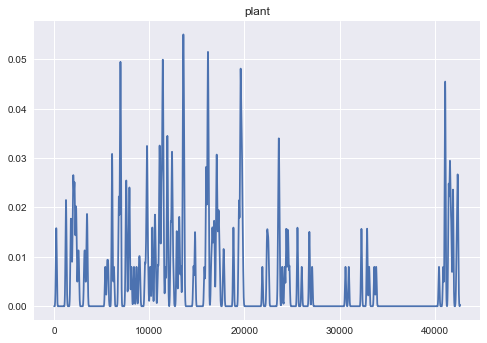

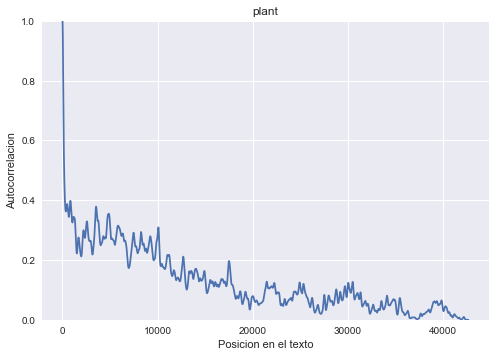

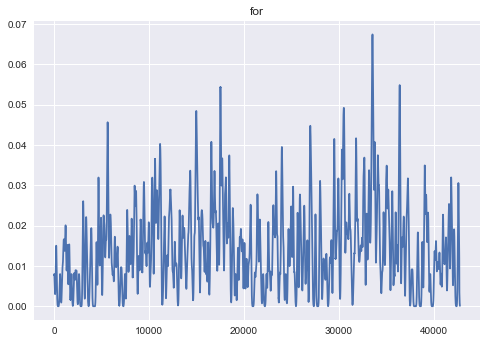

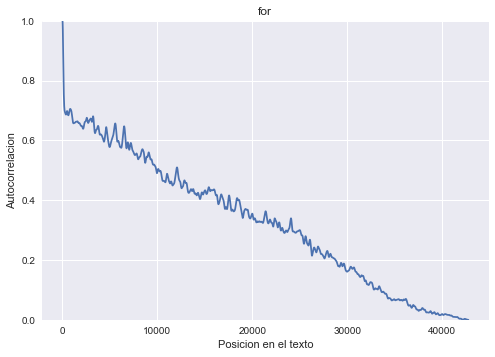

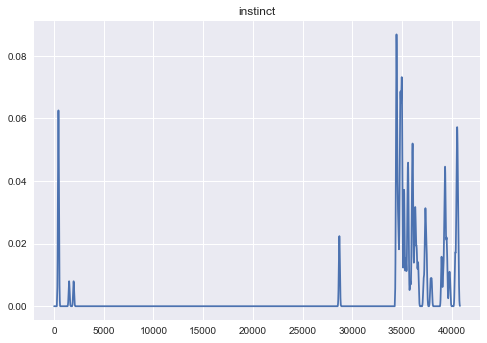

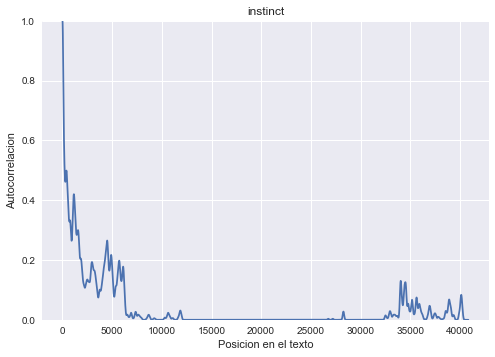

In [19]:
words = ['plant', 'for', 'instinct']
sigma = 50
for word in words:
    rate_word = []
    mascara_palabra = [word == lema for lema in lematizados]
    ultimo = 0
    for j in range(len(mascara_palabra)):
        valores_normales = []
        start = max(0, j - 3*sigma)
        # Calcular todos los valores de la normal es muy lento
        # Así que aprovecho que la dirac es esparsa para calcular solo los que necesito
        for x in range(start, min(len(mascara_palabra) - 1, j+3*sigma)):
            if (x + start >= len(mascara_palabra)): break
            norm = 0
            if mascara_palabra[x]:
                norm = sp.stats.norm.pdf(j, loc = x, scale = 50)
            valores_normales.append(norm)
        suma_normales = sum(valores_normales)
        if suma_normales != 0:
            ultimo = j
        rate_word.append(suma_normales)
    # Esto me da la autocorrelación desde distancia negativa máxima a positiva máxima
    rate_word_aux = rate_word[:ultimo+1]
    plt.plot(rate_word_aux)
    plt.title(word)
    plt.show()
    y = np.correlate(rate_word_aux, rate_word_aux, "full")
    # Me quedo con las positivas
    y = y[int(len(y)/2):]
    # Normalizo
    y = [yi/y[0] for yi in y]
    plt.plot(range(len(y)), y)
    plt.ylim(0, 1)
    plt.title(word)
    plt.xlabel("Posicion en el texto")
    plt.ylabel("Autocorrelacion")
    plt.show()

## 2.3)

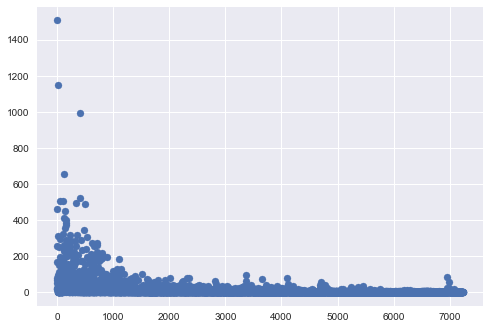

In [20]:
#obtenemos las 100 seleccionadas
vocabularioOrigin = {}
for word in lematizados: 
    if word in vocabularioOrigin:
        vocabularioOrigin[word] += 1
    else:
        vocabularioOrigin[word] = 1

        
sortedOrigin = [word for word in sorted(vocabularioOrigin, key=vocabularioOrigin.get, reverse=False)]
skipValue = len(sortedOrigin) // 500
selected100 = [sortedOrigin[i] for i in range(0,len(sortedOrigin), skipValue)]
    

plt.scatter(range(len([tup[0] for tup in vocabularioOrigin.items()])), [tup[1] for tup in vocabularioOrigin.items()])
plt.show()
#mostRepeated50 = [word for word in sorted(vocabularioOrigin, key=vocabularioOrigin.get, reverse=True)][0:50]
#leastRepeated50 = [word for word in sorted(vocabularioOrigin, key=vocabularioOrigin.get, reverse=False)][0:50]
#selected100 = leastRepeated50 + mostRepeated50

graficamos las palabras por frecuencias y observamos su distribucion, para asegurarnos de que estabamos tomando 100 palabras representativas... we do mah man


/home/javier/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:2505: RuntimeWarning: invalid value encountered in true_divide
  pk = 1.0*pk / np.sum(pk, axis=0)


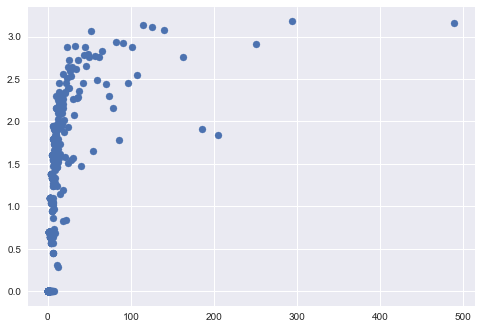

In [21]:
#calculamos entropia
def entropia(word, text):
    p = 3000
    division = len(text) // p
    partitions = [text[p*i : p*(i+1)] for i in range(division-1)]
    
    probs = []
    for partition in partitions:
        aparicionesWord = sum([word == w for w in partition])
        prob = aparicionesWord / len(partition)
        probs.append(prob)
    return sp.stats.entropy(probs)

entropySelected100 = []
for word in selected100:
    entropySelected100.append(entropia(word, lematizados))

plt.scatter([vocabularioOrigin[key] for key in selected100], entropySelected100)
plt.show()

## 2.4)

/home/javier/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:2505: RuntimeWarning: invalid value encountered in true_divide
  pk = 1.0*pk / np.sum(pk, axis=0)


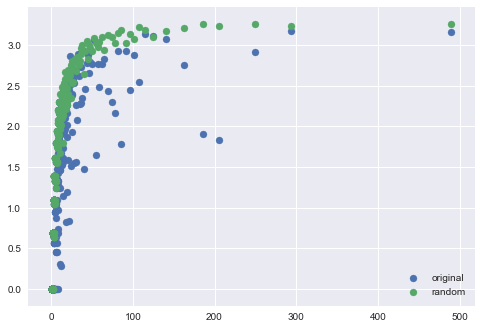

In [22]:
tokensRandom = list(lematizados)
shuffle(tokensRandom)
entropySelectedRandom100 = []
for word in selected100:
    entropySelectedRandom100.append(entropia(word, tokensRandom))

plt.scatter([vocabularioOrigin[key] for key in selected100], entropySelected100, label = 'original')
plt.scatter([vocabularioOrigin[key] for key in selected100], entropySelectedRandom100, label = 'random')
plt.legend()
plt.show()

pusimos 500 por que mira que cheto.


## 3.1)Utilizando el test WordSim353, comparar el rendimiento entre LSA y Word2Vec.

In [23]:
#reescribo el texto
word_sim_file = open('wordsim353/wordsim353_agreed.txt', 'r')
word_sim = [x.strip().split('\t')[1:] for x in word_sim_file if x[0] !='#']

In [24]:
diccionario = corpora.Dictionary(brown.sents())
corpora.MmCorpus.serialize('corpus.mm', (diccionario.doc2bow(text) for text in brown.sents()))
corpus = corpora.MmCorpus('corpus.mm')

lsi = models.LsiModel(corpus, id2word=diccionario)

word_vec = models.Word2Vec(brown.sents())



In [80]:
brown_ic = wn.ic(brown, False, 0.0)
similitudes = pd.DataFrame(columns=['hum', 'lsa', 'w2v','lch', 'wup', 'path', 'res', 'jcn'])

for w1, w2, score in word_sim:
    if w1 in word_vec.wv.vocab and w2 in word_vec.wv.vocab:
        word_net1 = wn.synsets(w1)[0]
        word_net2 = wn.synsets(w2)[0]
        
        try:
            #distintas longitudes no good
            word1 = [x[1] for x in lsi[diccionario.doc2bow([w1])]]
            word2 = [x[1] for x in lsi[diccionario.doc2bow([w2])]]

            
            lch = word_net1.lch_similarity(word_net2)
            wup = word_net1.wup_similarity(word_net2)
            path = word_net1.path_similarity(word_net2)
            res = word_net1.res_similarity(word_net2, brown_ic)
            jcn = word_net1.jcn_similarity(word_net2, brown_ic)
            lin = word_net1.lin_similarity(word_net2, brown_ic)
            lsa = sp.spatial.distance.cosine(word1, word2)
            w2v = word_vec.wv.similarity(w1, w2)
            
            
            dic = {'hum': float(score), 'lsa': lsa, 'w2v': w2v,'lch': lch, 'wup': wup, 'path': path, 'res': res, 'jcn': jcn}

            similitudes = similitudes.append(dic, ignore_index = True)
        except WordNetError:
            continue


In [81]:
def normalizar_df(data):
    return (data - data.min(axis = 0))/ (data.max(axis=0)- data.min(axis=0))    

simil_norm = normalizar_df(similitudes)    
print(similitudes.columns)

Index(['hum', 'lsa', 'w2v', 'lch', 'wup', 'path', 'res', 'jcn'], dtype='object')


In [82]:
def distancias(data):
    metodos = ['lsa', 'w2v']
    columnas = data.columns
    print(columnas)
    for col in columnas:
        if not(col in metodos):
            for met in metodos:
                dist = 'dist_'+met+'_'+col
                data[dist] = abs(data[met]-data[col])  
                print(dist)
    return data

simil_norm = distancias(simil_norm)

Index(['hum', 'lsa', 'w2v', 'lch', 'wup', 'path', 'res', 'jcn'], dtype='object')
dist_lsa_hum
dist_w2v_hum
dist_lsa_lch
dist_w2v_lch
dist_lsa_wup
dist_w2v_wup
dist_lsa_path
dist_w2v_path
dist_lsa_res
dist_w2v_res
dist_lsa_jcn
dist_w2v_jcn


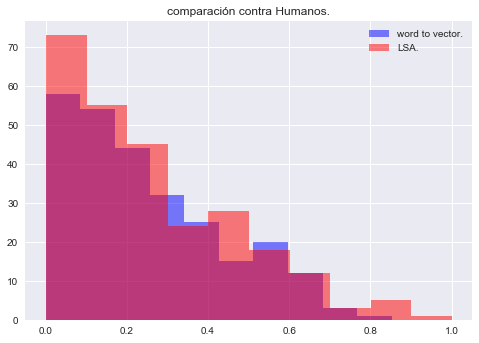

In [83]:

plt.hist(simil_norm['dist_w2v_hum'], color = 'b', alpha = 0.5, label = 'word to vector.')
plt.hist(simil_norm['dist_lsa_hum'], color = 'r', alpha = 0.5, label = 'LSA.')
plt.legend()
plt.title('comparación contra Humanos.')
plt.show()


Leacock & Chodorow: encuentra el camino más corto entre dos conceptos y escala ese valor por el maximo largo del camino en la jerarquia is-a en la cual ocurre.


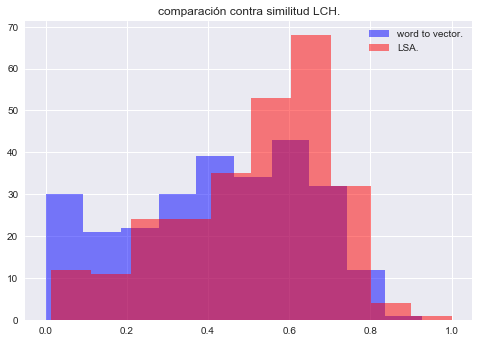

In [84]:
plt.hist(simil_norm['dist_w2v_lch'], color = 'b', alpha = 0.5, label = 'word to vector.')
plt.hist(simil_norm['dist_lsa_lch'], color = 'r', alpha = 0.5, label = 'LSA.')
plt.legend()
plt.title('comparación contra similitud LCH.')
plt.show()

Wu  & Palmer: encuentra el largo del camino hacia el nodo raiz desde el least common subsumer (LCS) de los dos conceptos, el cual es el concepro mas especifico que comparten como ancestro. Este calor se escala por la suma de los largos de los caminos desde los conceptos individuales hasta la raiz.


In [20]:


plt.hist(simil_norm['dist_w2v_wup'], color = 'b', alpha = 0.5, label = 'word to vector.')
plt.hist(simil_norm['dist_lsa_wup'], color = 'r', alpha = 0.5, label = 'LSA.')
plt.legend()
plt.title('comparación contra similitud WUP.')
plt.show()



3

path: es igual al inverso del largo del camino más corto entre los dos conceptos.


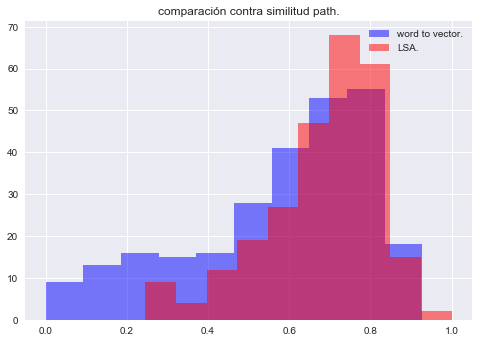

In [85]:
plt.hist(simil_norm['dist_w2v_path'], color = 'b', alpha = 0.5, label = 'word to vector.')
plt.hist(simil_norm['dist_lsa_path'], color = 'r', alpha = 0.5, label = 'LSA.')
plt.legend()
plt.title('comparación contra similitud path.')
plt.show()

res: Este se basa en la medida de información de shannon sobre su ancestro comun mas cercano. (por ejemplo vaca y gato, tienen como el acenstro comun mas cercano a la palabra mamifero). Esta medida de información y las siguientes se basan en un corpus, el corpus que elegimos fue el de brown.

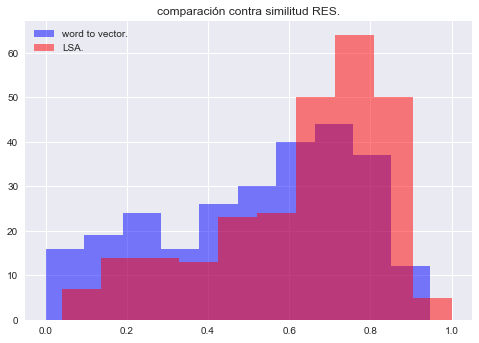

In [86]:
plt.hist(simil_norm['dist_w2v_res'], color = 'b', alpha = 0.5, label = 'word to vector.')
plt.hist(simil_norm['dist_lsa_res'], color = 'r', alpha = 0.5, label = 'LSA.')
plt.legend()
plt.title('comparación contra similitud RES.')
plt.show()

jcn: Tiene las mismas ideas que Resnik, pero tambien usa la información de los dos conceptos en los que se miden la similitud. la cuenta es:  1 / (IC(s1) + IC(s2) - 2 * IC(lcs)) (donde lcs es el ancestro comun mas cercano).



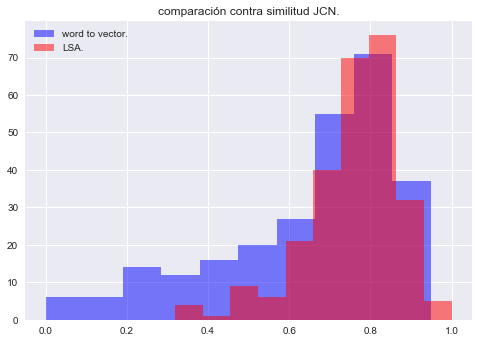

In [87]:
plt.hist(simil_norm['dist_w2v_jcn'], color = 'b', alpha = 0.5, label = 'word to vector.')
plt.hist(simil_norm['dist_lsa_jcn'], color = 'r', alpha = 0.5, label = 'LSA.')
plt.legend()
plt.title('comparación contra similitud JCN.')
plt.show()

http://www.d.umn.edu/~tpederse/Pubs/AAAI04PedersenT.pdf